# Minimum-Viable Product (MVP) Modeling
- Use the significant features from MVP exploration
    1. srv_count
    2. num_failed_logins
- Resample classes if necessary using SMOTE+Tomek
- Scale features
- Calculate baseline (guessing anomaly)
- Build a classification model and fit on train's two features and target
- Evaluate model on train and validate
    * Main metric: F1 Score
- Report findings of MVP model

# Setup

In [1]:
# imports
import pyspark
from pyspark.sql.functions import *
spark = pyspark.sql.SparkSession.builder.getOrCreate()

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from imblearn.combine import SMOTETomek

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import wrangle

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/24 15:23:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/01/24 15:23:57 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
# data ingest, prep, and split
train, validate, test = wrangle.prep_model_MVP()
print('Train shape:', train.shape)
print('Validate shape:', validate.shape)
print('Test shape:', test.shape)

Train shape: (606701, 3)
Validate shape: (362816, 3)
Test shape: (242379, 3)


In [3]:
# isolate target column in each split
X_train, y_train = train.drop(columns='target'), train.target
X_validate, y_validate = validate.drop(columns='target'), validate.target
X_test, y_test = test.drop(columns='target'), test.target

# Check if Need to Resample Train
If the distribution is skewed, we will need to resample to bring each class into parity. This will increase our model's performance.

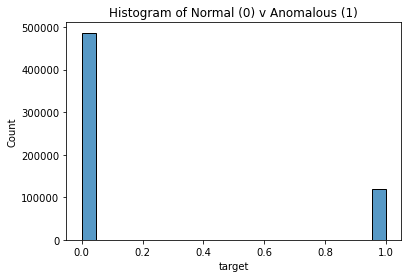

In [4]:
# check distribution
sns.histplot(y_train)
plt.title('Histogram of Normal (0) v Anomalous (1)')
plt.show()

1. Based on the distribution, we will oversample the Anomalous class and undersample the Normal class using SMOTE+Tomek.
2. We will resample after we have scaled our features.

# Scaling

In [5]:
# build and fit scaler on train, transform all splits
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

# check work
X_train_scaled

array([[0.00195695, 0.        ],
       [0.00195695, 0.        ],
       [0.00195695, 0.        ],
       ...,
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ]])

# Resampling Train Split
Resampling is needed here, but it will take several minutes to complete on a low-performance laptop. Spark does not have a mechanism for this resampling.

In [6]:
# build resampler
smtom = SMOTETomek(random_state=42)
# resample the training split
X_train_smtom, y_train_smtom = smtom.fit_resample(pd.DataFrame(X_train_scaled), y_train)

# check work
print('Shape before resampling:', X_train_scaled.shape)
print('Shape after resampling:', X_train_smtom.shape)

Shape before resampling: (606701, 2)
Shape after resampling: (973584, 2)


# Calculate, Evaluate Baseline
We will guess 'anomalous' for every observation as a baseline. Because we've resampled the dataset, this baseline will have 50% accuracy on in-sample data but lower accuracy on out-of-sample data.

In [7]:
# create, evaluate baseline for in-sample (train)
bl_report_train = pd.DataFrame(
    classification_report(
        y_train_smtom,
        pd.Series([1 for _ in y_train_smtom]), 
        labels=[1, 0], 
        output_dict=True
    )
).T

# create, evaluate baseline for out-of-sample (validate)
bl_report_validate = pd.DataFrame(
    classification_report(
        y_validate,
        pd.Series([1 for _ in y_validate]), 
        labels=[1, 0], 
        output_dict=True
    )
).T

/opt/homebrew/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/

# Build Classification Model

In [8]:
# build random forest classification model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_smtom, y_train_smtom)

RandomForestClassifier(random_state=42)

# Evaluate Model on In-Sample and Out-of-Sample Data

In [9]:
# predict on train and validate
rf_train_predictions = rf.predict(X_train_smtom)
rf_validate_predictions = rf.predict(X_validate_scaled)

In [10]:
# evaluate using classification report
rf_report_train = pd.DataFrame(
    classification_report(
        y_train_smtom, 
        rf_train_predictions, 
        labels=[1, 0], 
        output_dict=True
    )
).T

# evaluate using classification report
rf_report_validate = pd.DataFrame(
    classification_report(
        y_validate, 
        rf_validate_predictions, 
        labels=[1, 0], 
        output_dict=True
    )
).T

# Baseline and Model Results

In [11]:
# baseline on in-sample
bl_report_train

,precision,recall,f1-score,support
1,0.50,1.0,0.666667,486792.0
0,0.00,0.0,0.000000,486792.0
accuracy,0.50,0.5,0.500000,0.5
macro avg,0.25,0.5,0.333333,973584.0
weighted avg,0.25,0.5,0.333333,973584.0


In [12]:
# baseline on out-of-sample
bl_report_validate

,precision,recall,f1-score,support
1,0.196510,1.00000,0.328472,71297.00000
0,0.000000,0.00000,0.000000,291519.00000
accuracy,0.196510,0.19651,0.196510,0.19651
macro avg,0.098255,0.50000,0.164236,362816.00000
weighted avg,0.038616,0.19651,0.064548,362816.00000


In [13]:
# our model on in-sample
rf_report_train

,precision,recall,f1-score,support
1,0.981474,0.596296,0.741868,486792.00000
0,0.710076,0.988745,0.826554,486792.00000
accuracy,0.792520,0.792520,0.792520,0.79252
macro avg,0.845775,0.792520,0.784211,973584.00000
weighted avg,0.845775,0.792520,0.784211,973584.00000


In [14]:
# our model on out-of-sample
rf_report_validate

,precision,recall,f1-score,support
1,0.927900,0.595677,0.725567,71297.000000
0,0.909076,0.988680,0.947209,291519.000000
accuracy,0.911451,0.911451,0.911451,0.911451
macro avg,0.918488,0.792179,0.836388,362816.000000
weighted avg,0.912775,0.911451,0.903654,362816.000000


# Modeling MVP Takeaways
With just two features, our Random Forest model (with no hyperparameter tuning) vastly outperformed our baseline. Here are the results:

## 1. Baseline F1 Scores: 67% on in-sample, 33% on out-of-sample
## 2. Random Forest F1 Scores: 74% on in-sample, 73% on out-of-sample